# ETL process for Census Annual Business Survey
Every year The United States Census Bureau conducts their [Annual Business Survey (ABS)](https://www.census.gov/programs-surveys/abs/about.html) electronically. It provides information on selected economic and demographic characteristics for businesses and business owners by sex, ethnicity, race, and veteran status.

In this project, we plan to use the ABS to learn more about demographics in The United States' businesses. Below you will find an outline for the Extract, Transform, and Load (ETL) process for the data.

## Extract
1. Import the `api_key` from the config file in order to run API requests
2. Set up API requests with appropriate links, formatting the `api_key`
3. Call the API for each request and store the outcome as a DataFrame using `API2DataFrame`

In [1]:
#import relevant libraries
import requests
from config import api_key
import json
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#URLs
business_owner_url = f'https://api.census.gov/data/2018/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,OWNER_SEX,OWNER_SEX_LABEL,OWNER_ETH,OWNER_ETH_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_VET,OWNER_VET_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,YEAR,OWNPDEMP,OWNPDEMP_F,OWNPDEMP_PCT,OWNPDEMP_PCT_F,OWNPDEMP_S,OWNPDEMP_S_F,OWNPDEMP_PCT_S,OWNPDEMP_PCT_S_F&for=us:*&for=QDESC_LABEL=ACQBUS&key={api_key}'

business_characteristics_url = f'https://api.census.gov/data/2018/abscb?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,QDESC,QDESC_LABEL,BUSCHAR,BUSCHAR_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,FIRMPDEMP_PCT,FIRMPDEMP_PCT_F,RCPPDEMP,RCPPDEMP_F,RCPPDEMP_PCT,RCPPDEMP_PCT_F,EMP,EMP_F,EMP_PCT,EMP_PCT_F,PAYANN,PAYANN_F,PAYANN_PCT,PAYANN_PCT_F,FIRMPDEMP_S,FIRMPDEMP_S_F,FIRMPDEMP_PCT_S,FIRMPDEMP_PCT_S_F,RCPPDEMP_S,RCPPDEMP_S_F,RCPPDEMP_PCT_S,RCPPDEMP_PCT_S_F,EMP_S,EMP_S_F,EMP_PCT_S,EMP_PCT_S_F,PAYANN_S,PAYANN_S_F,PAYANN_PCT_S,PAYANN_PCT_S_F&for=us:*&for=QDESC_LABEL=SPOUSES&key={api_key}'

company_summary_url = f'https://api.census.gov/data/2018/abscs?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,EMPSZFI,EMPSZFI_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,RCPPDEMP,RCPPDEMP_F,EMP,EMP_F,PAYANN,PAYANN_F,FIRMPDEMP_S,FIRMPDEMP_S_F,RCPPDEMP_S,RCPPDEMP_S_F,EMP_S,EMP_S_F,PAYANN_S,PAYANN_S_F&for=us:*&key={api_key}'

In [3]:
def API2DataFrame(url):
    '''
    url: str
    
    takes in url for API and returns a pandas DataFrame
    '''
    #Gather data from the API
    response = requests.get(url)
    #Load data into DataFrame
    df = pd.DataFrame(response.json())
    #Grab the first row for the header
    new_header = df.iloc[0]
    #Take the data other than the header row
    df = df[1:]
    #Set the header row as the df header
    df.columns = new_header
    #Append DataFrame to the data_frames list
    return df

Let's begin by calling from the API and loading the data into a `pandas` DataFrame

In [4]:
#DataFrames
business_owner_characteristics = API2DataFrame(business_owner_url)

business_characteristics = API2DataFrame(business_characteristics_url)

company_summary = API2DataFrame(company_summary_url)

## Transform
1. Remove unwanted data columns from the DataFrame (different for each)
2. Drop columns and rows where all entries are NA
3. Remove records where there is a 'withheld' flag (see D flag in [ABS Documentation](https://www2.census.gov/programs-surveys/abs/technical-documentation/api/ABS_API_CB-10-4-2021.pdf))
4. After filtering flags appropriately, drop flag columns

These steps can all be done by calling `cleanDataFrame()` and feeding it:
* `dataframe` : a `pandas` DataFrame (e.g. those pre-loaded in the Extract step above)
* `drop_columns` : a list of columns to be dropped from the DataFrame
* `filter_columns` : a list of columns to check for flags and filter

The function will then return a cleaned DataFrame

In [5]:
def cleanDataFrame(dataframe, drop_columns = [], filter_columns = []):
    '''
    dataframe: a pandas DataFrame
    drop_columns: list of columns to be dropped from dataframe
    filter_columns: list of columns that act as filter/flags for the record
    
    Takes in a pandas dataframe and drops unwanted columns and cleans data according to flag/filters
    '''
    
    #Remove unwanted columns
    dataframe = dataframe.drop(columns = drop_columns)
    
    #Remove all columns and rows that have all null values
    dataframe.dropna(axis='columns', how='all',inplace=True)
    dataframe.dropna(axis='rows', how='all',inplace=True)
    
    #Remove all records where there is a flag
    for column in filter_columns:
        #Remove records for one flag at a time
        dataframe.drop(dataframe.loc[dataframe[column] == 'D'].index, inplace=True)
        
    #After filtering flags, we can remove flag columns
    dataframe.drop(columns = filter_columns, inplace = True)
    
    
    return dataframe
    

## Business Owner Characteristics

In [6]:
business_owner_characteristics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104622 entries, 1 to 104622
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   GEO_ID            104622 non-null  object
 1   NAME              104622 non-null  object
 2   NAICS2017         104622 non-null  object
 3   NAICS2017_LABEL   104622 non-null  object
 4   OWNER_SEX         104622 non-null  object
 5   OWNER_SEX_LABEL   104622 non-null  object
 6   OWNER_ETH         104622 non-null  object
 7   OWNER_ETH_LABEL   104622 non-null  object
 8   OWNER_RACE        104622 non-null  object
 9   OWNER_RACE_LABEL  104622 non-null  object
 10  OWNER_VET         104622 non-null  object
 11  OWNER_VET_LABEL   104622 non-null  object
 12  QDESC             104622 non-null  object
 13  QDESC_LABEL       104622 non-null  object
 14  OWNCHAR           104622 non-null  object
 15  OWNCHAR_LABEL     104622 non-null  object
 16  YEAR              104622 non-null  obj

You may notice that some of these columns have codes and are repeated with labels. Let's go ahead and remove the columns that do not add to the data/are redundant

In [7]:
# For each data frame, we'll want to drop specific columns
# Business owner characteristics: GEO_ID, NAICS2017, OWNER_SEX, OWNER_ETH, OWNER_RACE, OWNER_VET, QDESC, OWNCHAR, YEAR, state
drop_columns = ['GEO_ID', 'NAICS2017', 'OWNER_SEX', 'OWNER_ETH', 'OWNER_RACE',
                'OWNER_VET', 'QDESC', 'QDESC_LABEL', 'OWNCHAR', 'YEAR', 'us']

flag_columns = ['OWNPDEMP_F', 'OWNPDEMP_PCT_F', 'OWNPDEMP_S_F', 'OWNPDEMP_PCT_S_F']

business_owner_characteristics = cleanDataFrame(business_owner_characteristics, drop_columns = drop_columns, filter_columns = flag_columns)

In [8]:
business_owner_characteristics

,NAME,NAICS2017_LABEL,OWNER_SEX_LABEL,OWNER_ETH_LABEL,OWNER_RACE_LABEL,OWNER_VET_LABEL,OWNCHAR_LABEL,OWNPDEMP,OWNPDEMP_PCT,OWNPDEMP_S,OWNPDEMP_PCT_S
1,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,2013 to 2017,21939,29.9,5.1,1.2
2,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,2018,912,1.2,20.3,0.3
3,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,Don't know,7441,10.1,4.2,0.5
4,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,Total reporting,73427,100.0,2.1,0.0
5,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,Item not reported,3106,0.0,5.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
104618,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Business was purchased by another company,24,0.4,35.8,0.1
104619,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Business was purchased by another individual,17,0.3,76.7,0.2
104620,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Other,273,4.4,17.7,0.8
104621,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Total reporting,6221,100.0,2.6,0.0


Notice that some of the data is numerical (and in percents). Let's make sure the data is stored as floats

In [9]:
business_owner_characteristics['OWNPDEMP_PCT'] = business_owner_characteristics['OWNPDEMP_PCT'].astype(float)
business_owner_characteristics['OWNPDEMP_S'] = business_owner_characteristics['OWNPDEMP_S'].astype(float)
business_owner_characteristics['OWNPDEMP_PCT_S'] = business_owner_characteristics['OWNPDEMP_PCT_S'].astype(float)

In [10]:
business_owner_characteristics

,NAME,NAICS2017_LABEL,OWNER_SEX_LABEL,OWNER_ETH_LABEL,OWNER_RACE_LABEL,OWNER_VET_LABEL,OWNCHAR_LABEL,OWNPDEMP,OWNPDEMP_PCT,OWNPDEMP_S,OWNPDEMP_PCT_S
1,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,2013 to 2017,21939,29.9,5.1,1.2
2,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,2018,912,1.2,20.3,0.3
3,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,Don't know,7441,10.1,4.2,0.5
4,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,Total reporting,73427,100.0,2.1,0.0
5,United States,Total for all sectors,All owners of respondent firms,All owners of respondent firms,Black or African American,All owners of respondent firms,Item not reported,3106,0.0,5.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
104618,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Business was purchased by another company,24,0.4,35.8,0.1
104619,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Business was purchased by another individual,17,0.3,76.7,0.2
104620,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Other,273,4.4,17.7,0.8
104621,United States,Industries not classified,Male,All owners of respondent firms,All owners of respondent firms,All owners of respondent firms,Total reporting,6221,100.0,2.6,0.0


In [11]:
business_owner_characteristics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92564 entries, 1 to 104622
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NAME              92564 non-null  object 
 1   NAICS2017_LABEL   92564 non-null  object 
 2   OWNER_SEX_LABEL   92564 non-null  object 
 3   OWNER_ETH_LABEL   92564 non-null  object 
 4   OWNER_RACE_LABEL  92564 non-null  object 
 5   OWNER_VET_LABEL   92564 non-null  object 
 6   OWNCHAR_LABEL     92564 non-null  object 
 7   OWNPDEMP          92564 non-null  object 
 8   OWNPDEMP_PCT      92564 non-null  float64
 9   OWNPDEMP_S        92564 non-null  float64
 10  OWNPDEMP_PCT_S    92564 non-null  float64
dtypes: float64(3), object(8)
memory usage: 8.5+ MB


### Some EDA on owner characteristics

In [12]:
#Unique values for ethnicity
business_owner_characteristics['OWNER_ETH_LABEL'].value_counts()

All owners of respondent firms    73216
Non-Hispanic                      10944
Hispanic                           8404
Name: OWNER_ETH_LABEL, dtype: int64

In [13]:
owner_ethnicity = business_owner_characteristics['OWNER_ETH_LABEL'].value_counts()

In [14]:
owner_ethnicity

All owners of respondent firms    73216
Non-Hispanic                      10944
Hispanic                           8404
Name: OWNER_ETH_LABEL, dtype: int64

In [15]:
non_total_owner_ethnicity = owner_ethnicity[1:]

<AxesSubplot:>

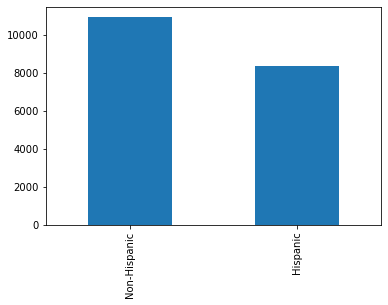

In [16]:
non_total_owner_ethnicity.plot(kind='bar')

In [17]:
#unique values for race
business_owner_characteristics['OWNER_RACE_LABEL'].value_counts()

All owners of respondent firms                37833
White                                         10942
Nonminority                                   10917
Minority                                       9433
Asian                                          7948
Black or African American                      7059
American Indian and Alaska Native              5478
Native Hawaiian and Other Pacific Islander     2954
Name: OWNER_RACE_LABEL, dtype: int64

In [18]:
#unique values for race
owner_race_data = business_owner_characteristics['OWNER_RACE_LABEL'].value_counts()

In [19]:
owner_race_data

All owners of respondent firms                37833
White                                         10942
Nonminority                                   10917
Minority                                       9433
Asian                                          7948
Black or African American                      7059
American Indian and Alaska Native              5478
Native Hawaiian and Other Pacific Islander     2954
Name: OWNER_RACE_LABEL, dtype: int64

In [20]:
#Remove the 'total' entries
non_total_owner_race_data = owner_race_data[[1, 4, 5, 6, 7]]

<AxesSubplot:>

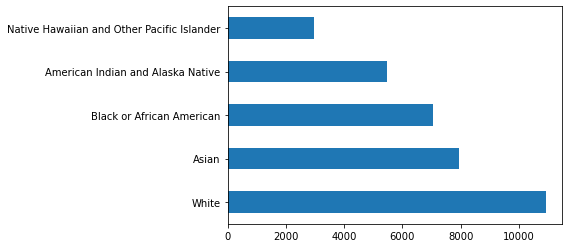

In [21]:
non_total_owner_race_data.plot(kind='barh')

In [22]:
#Unique values for sex
business_owner_characteristics['OWNER_SEX_LABEL'].unique()

array(['All owners of respondent firms', 'Female', 'Male'], dtype=object)

In [23]:
owner_sex_data = business_owner_characteristics['OWNER_SEX_LABEL'].value_counts()

In [24]:
non_total_owner_sex_data = owner_sex_data[1:]

<AxesSubplot:>

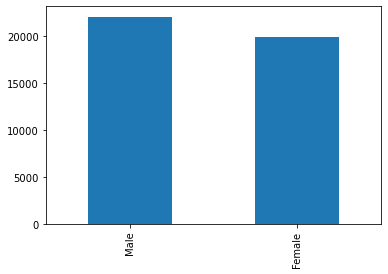

In [25]:
non_total_owner_sex_data.plot(kind='bar')

In [26]:
#Owner Veteran Status
owner_vet = business_owner_characteristics['OWNER_VET_LABEL'].value_counts()

In [27]:
owner_vet_status = owner_vet[1:]

<AxesSubplot:>

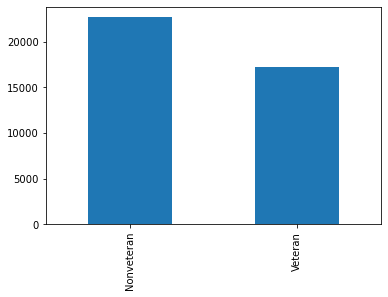

In [28]:
owner_vet_status.plot(kind='bar')

## Business Characteristics

In [30]:
business_characteristics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48737 entries, 1 to 48737
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   GEO_ID             48737 non-null  object
 1   NAME               48737 non-null  object
 2   NAICS2017          48737 non-null  object
 3   NAICS2017_LABEL    48737 non-null  object
 4   SEX                48737 non-null  object
 5   SEX_LABEL          48737 non-null  object
 6   ETH_GROUP          48737 non-null  object
 7   ETH_GROUP_LABEL    48737 non-null  object
 8   RACE_GROUP         48737 non-null  object
 9   RACE_GROUP_LABEL   48737 non-null  object
 10  VET_GROUP          48737 non-null  object
 11  VET_GROUP_LABEL    48737 non-null  object
 12  QDESC              48737 non-null  object
 13  QDESC_LABEL        48737 non-null  object
 14  BUSCHAR            48737 non-null  object
 15  BUSCHAR_LABEL      48737 non-null  object
 16  YEAR               48737 non-null  objec

You may notice that some of these columns have codes and are repeated with labels. Let's go ahead and remove the columns that do not add to the data/are redundant

In [31]:
# For each data frame, we'll want to drop specific columns
# Business characteristics: GEO_ID, NAICS2017, SEX, ETH_GROUP, RACE_GROUP, VET_GROUP, QDESC, BUSCHAR, YEAR, us
drop_columns = ['GEO_ID', 'NAICS2017', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP', 'QDESC', 'BUSCHAR', 'YEAR', 'us']
flag_columns = ['FIRMPDEMP_F', 'FIRMPDEMP_PCT_F', 'RCPPDEMP_F', 'RCPPDEMP_PCT_F', 'EMP_F', 'EMP_PCT_F', 'PAYANN_F',
                'PAYANN_PCT_F', 'FIRMPDEMP_S_F', 'FIRMPDEMP_PCT_S_F', 'RCPPDEMP_S_F', 'RCPPDEMP_PCT_S_F', 'EMP_S_F',
                'EMP_PCT_S_F', 'PAYANN_S_F', 'PAYANN_PCT_S_F']

business_characteristics = cleanDataFrame(business_characteristics, drop_columns = drop_columns, filter_columns = flag_columns)

In [32]:
business_charactristics

,NAME,NAICS2017_LABEL,SEX_LABEL,ETH_GROUP_LABEL,RACE_GROUP_LABEL,VET_GROUP_LABEL,QDESC_LABEL,BUSCHAR_LABEL,FIRMPDEMP,FIRMPDEMP_PCT,...,PAYANN,PAYANN_PCT,FIRMPDEMP_S,FIRMPDEMP_PCT_S,RCPPDEMP_S,RCPPDEMP_PCT_S,EMP_S,EMP_PCT_S,PAYANN_S,PAYANN_PCT_S
1,United States,Total for all sectors,Total,Total,Total,Total,OWNRNUM,All firms,5722142,0.0,...,6937240308,0.0,0.0,0.0,1.2,0.0,0.5,0.0,0.5,0.0
2,United States,Total for all sectors,Total,Total,Total,Total,OWNRNUM,1 person,1628501,59.1,...,454218390,14.2,0.4,0.6,1.3,66.8,1.1,61.6,1.3,67.2
3,United States,Total for all sectors,Total,Total,Total,Total,OWNRNUM,2 to 4 people,1024784,37.2,...,478308387,15.0,0.6,0.3,3.0,87.0,1.5,68.9,2.7,77.9
4,United States,Total for all sectors,Total,Total,Total,Total,OWNRNUM,5 to 10 people,49436,1.8,...,75150602,2.4,2.5,0.1,7.8,12.4,4.8,7.0,4.2,10.1
5,United States,Total for all sectors,Total,Total,Total,Total,OWNRNUM,11 or more people,31846,1.2,...,986906070,30.9,2.7,0.3,0.9,62.3,0.8,49.4,0.9,53.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48732,United States,Industries not classified,Equally male/female,Equally Hispanic/non-Hispanic,Total,Total,SPOUSES,Total reporting,0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48734,United States,Industries not classified,Total,Non-Hispanic,Total,Total,SPOUSES,All firms,20665,0.0,...,1147897,0.0,0.4,0.0,0.0,0.0,20.8,0.0,3.1,0.0
48735,United States,Industries not classified,Total,Non-Hispanic,Total,Total,SPOUSES,Jointly owned and equally operated by spouses,1587,28.4,...,69723,31.8,9.5,2.5,0.0,0.0,51.1,19.3,12.6,2.9
48736,United States,Industries not classified,Total,Non-Hispanic,Total,Total,SPOUSES,Jointly owned but primarily operated by male s...,1287,23.1,...,37239,17.0,8.4,1.8,0.0,0.0,36.7,9.8,13.1,2.1


## Company Summary

In [34]:
company_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19458 entries, 1 to 19458
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   GEO_ID            19458 non-null  object
 1   NAME              19458 non-null  object
 2   NAICS2017         19458 non-null  object
 3   NAICS2017_LABEL   19458 non-null  object
 4   SEX               19458 non-null  object
 5   SEX_LABEL         19458 non-null  object
 6   ETH_GROUP         19458 non-null  object
 7   ETH_GROUP_LABEL   19458 non-null  object
 8   RACE_GROUP        19458 non-null  object
 9   RACE_GROUP_LABEL  19458 non-null  object
 10  VET_GROUP         19458 non-null  object
 11  VET_GROUP_LABEL   19458 non-null  object
 12  EMPSZFI           19458 non-null  object
 13  EMPSZFI_LABEL     19458 non-null  object
 14  YEAR              19458 non-null  object
 15  FIRMPDEMP         19458 non-null  object
 16  FIRMPDEMP_F       7516 non-null   object
 17  RCPPDEMP    

In [35]:
# For each data frame, we'll want to drop specific columns
# company summary: GEO_ID, NAICS2017, SEX, ETH_GROUP, RACE_GROUP, VET_GROUP, EMPSZFI, YEAR, us
drop_columns = ['GEO_ID', 'NAICS2017', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP', 'EMPSZFI', 'YEAR', 'us']
flag_columns = ['FIRMPDEMP_F', 'RCPPDEMP_F', 'EMP_F', 'PAYANN_F', 'FIRMPDEMP_S_F', 'RCPPDEMP_S_F', 'EMP_S_F', 'PAYANN_S_F']

company_summary = cleanDataFrame(company_summary, drop_columns = drop_columns, filter_columns = flag_columns)

In [36]:
company_summary

,NAME,NAICS2017_LABEL,SEX_LABEL,ETH_GROUP_LABEL,RACE_GROUP_LABEL,VET_GROUP_LABEL,EMPSZFI_LABEL,FIRMPDEMP,RCPPDEMP,EMP,PAYANN,FIRMPDEMP_S,RCPPDEMP_S,EMP_S,PAYANN_S
1,United States,Total for all sectors,Female,Hispanic,Total,Total,All firms,84496,91103725,722654,21975675,3.0,8.9,7.7,7.0
2,United States,Total for all sectors,Female,Hispanic,Total,Total,Firms with no employees,10036,3233978,0,499996,4.7,19.2,0.0,13.5
3,United States,Total for all sectors,Female,Hispanic,Total,Total,Firms with 1 to 4 employees,47105,15792524,92631,2808773,4.7,8.2,4.8,7.4
4,United States,Total for all sectors,Female,Hispanic,Total,Total,Firms with 5 to 9 employees,12523,10688294,83449,2601817,5.9,4.3,5.6,6.3
5,United States,Total for all sectors,Female,Hispanic,Total,Total,Firms with 10 to 19 employees,8516,14105603,116479,3506384,6.0,16.2,6.7,10.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,United States,"Mining, quarrying, and oil and gas extraction",Equally male/female,Total,Nonminority,Total,Firms with 5 to 9 employees,451,0,3101,178609,37.9,0.0,38.8,37.4
19453,United States,"Mining, quarrying, and oil and gas extraction",Equally male/female,Total,Nonminority,Total,Firms with 10 to 19 employees,234,0,3313,168872,43.8,0.0,46.3,42.1
19454,United States,"Mining, quarrying, and oil and gas extraction",Equally male/female,Total,Nonminority,Total,Firms with 20 to 49 employees,0,0,0,0,0.0,0.0,0.0,0.0
19455,United States,"Mining, quarrying, and oil and gas extraction",Equally male/female,Total,Nonminority,Total,Firms with 50 to 99 employees,25,0,1369,108597,27.8,0.0,20.0,16.7


In [37]:
company_summary['NAICS2017_LABEL'].value_counts()

Total for all sectors                                                       1133
Professional, scientific, and technical services                             996
Health care and social assistance                                            963
Accommodation and food services                                              956
Administrative and support and waste management and remediation services     956
Manufacturing                                                                955
Transportation and warehousing                                               916
Retail trade                                                                 901
Construction                                                                 895
Wholesale trade                                                              860
Information                                                                  834
Other services (except public administration)                                820
Finance and insurance       